<a href="https://colab.research.google.com/github/GoldenSunFire/Depth-Estimation-Project/blob/main/zoe_depth_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to ZoeDepth Colab notebook

This notebook provides an easy to use interface for the depth estimation model "ZoeDepth".

It accompanies our paper : [ZoeDepth: Zero-shot Transfer by Combining Relative and Metric Depth](https://arxiv.org/abs/2302.12288v1)

# Setup

In [21]:
!pip install --upgrade timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.3 MB/s eta 0:00:00


In [22]:
!git clone https://github.com/isl-org/ZoeDepth.git

Cloning into 'ZoeDepth'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 111 (delta 41), reused 96 (delta 32), pack-reused 0
Receiving objects: 100% (111/111), 4.09 MiB | 25.51 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [23]:
cd ZoeDepth

/content/ZoeDepth


Sanity checks, to make sure everything is working

In [24]:
!python sanity.py

/usr/local/lib/python3.9/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or help(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use help(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
******************** Testing zoedepth ********************
Config:
{'attractor_alpha': 1000,
 'attractor_gamma': 2,
 'attractor_kind': 'mean',
 'attractor_type': 'inv',
 'aug': True,
 'bin_centers_type': 'softplus',
 'bin_embedding_dim': 128,
 'clip_gra

In [5]:
# Download file, only works on Chrome
#from google.colab import files
#files.download("pred.png")

# Load the model

In [25]:
import torch
from zoedepth.utils.misc import get_image_from_url, colorize
from PIL import Image
import matplotlib.pyplot as plt


zoe = torch.hub.load(".", "ZoeD_N", source="local", pretrained=True)

img_size [384, 512]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


In [26]:
zoe = zoe.to('cuda')

# Prediction

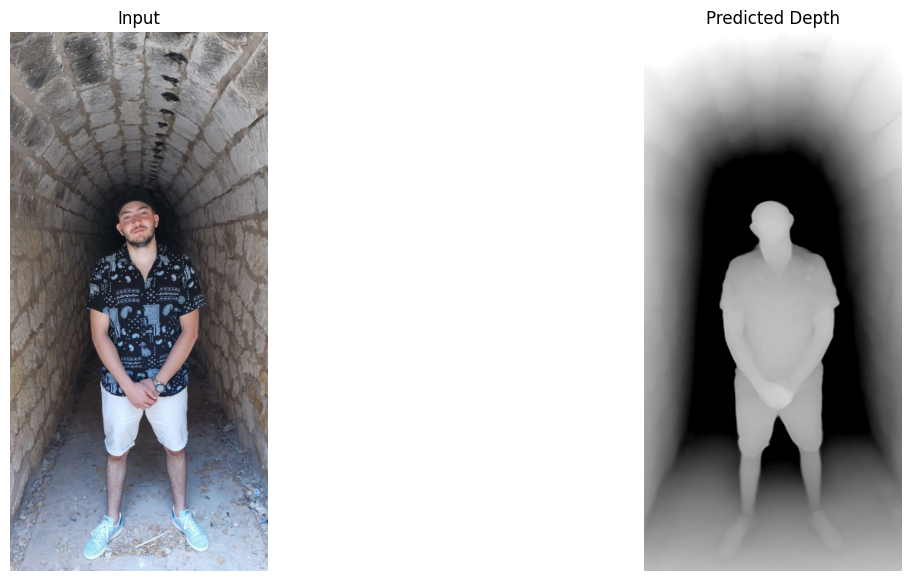

In [ ]:
#@title Predicting depth from a url image
#img_url = "/content/sample_data/TEST_1.jpg" #@param {type:"string"}
#img = get_image_from_url(img_url)
#depth = zoe.infer_pil(img)
# Local file
#from PIL import Image
#img = Image.open("/content/sample_data/h.jpg").convert("RGB")  # load
#depth = zoe.infer_pil(img)  # as numpy

#colored_depth = colorize(depth)
#fig, axs = plt.subplots(1,2, figsize=(15,7))
#for ax, im, title in zip(axs, [img, colored_depth], ['Input', 'Predicted Depth']):
 # ax.imshow(im)
  #ax.axis('off')
  #ax.set_title(title)

Scene: artroom1, View: 0
RMSE: 2.9481, MAE: 2.8434
Scene: bandsaw1, View: 0
RMSE: 2.4272, MAE: 2.4065
Scene: chess1, View: 0
RMSE: 2.0114, MAE: 1.9224
Scene: curule1, View: 0
RMSE: 2.0438, MAE: 1.9791
Scene: ladder1, View: 0
RMSE: 3.2972, MAE: 3.2213
Scene: octogons1, View: 0
RMSE: 2.7528, MAE: 2.7198
Scene: podium1, View: 0
RMSE: 2.9529, MAE: 2.8206
Scene: skates1, View: 0
RMSE: 1.8548, MAE: 1.7321


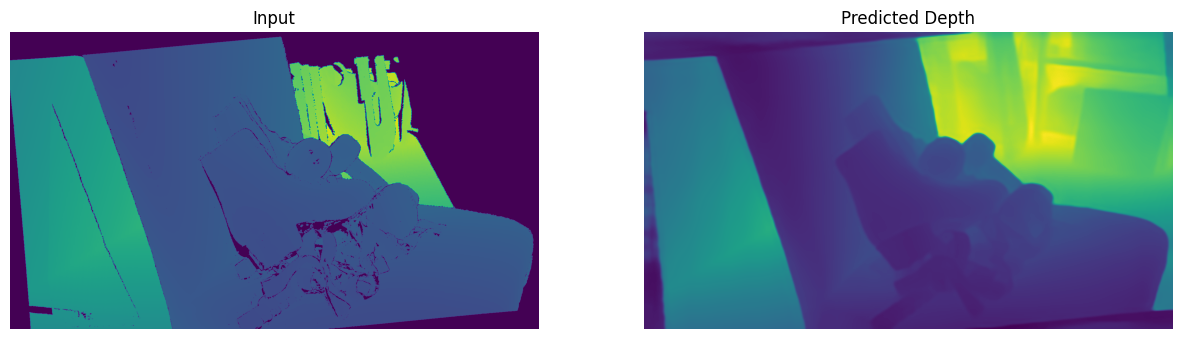

In [49]:
import os
import re
import numpy as np
from PIL import Image


# Define paths to the dataset
dataset_path = "/content/sample_data"  # Update with the actual path to your dataset

# Loop over scenes
for scene in ["artroom1", "bandsaw1","chess1","curule1","ladder1","octogons1","podium1","skates1"]:  # Update with the scene names in your dataset
    scene_path = os.path.join(dataset_path, scene.format(scene))

    # Read calibration parameters from calib.txt
    calib_file = os.path.join(scene_path, "calib.txt")
    with open(calib_file, "r") as f:
      lines = f.readlines()
      calib_params = {}
      for line in lines:
          key, value = line.strip().split("=")
          key = key.strip()
          value = value.strip().strip('[]')  # Updated to remove leading/trailing spaces and square brackets
          if key.startswith("cam"):
              cam_idx = int(key[3])  # Extract camera index from key, e.g., "cam0" -> 0
              cam_str = re.findall(r'\[(.*?)\]', line)[0]  # Extract string between square brackets
              cam_params = []
              for cam_params_idx in [0,1,2]:
                cam_params = np.concatenate((cam_params,[float(x) for x in cam_str.split(";")[cam_params_idx].split()]),axis=0)  # Split by semicolon and then by space
              cam_params = np.array(cam_params).reshape((3, 3))
              calib_params["baseline"] = cam_params[0, 2] / cam_params[0, 0]
              calib_params["focal_length"] = cam_params[1, 1]
          elif key == "baseline" or key == "focal_length":
              calib_params[key] = float(value)
          else:
              continue

    for view in [0]:
        img_path = os.path.join(scene_path, "im{}.png".format(view))
        img = Image.open(img_path).convert("RGB")

        # Infer depth using Zoe
        depth = zoe.infer_pil(img)

        # Load ground truth disparity
        disp_path = os.path.join(scene_path, "disp{}.pfm".format(view))
        with open(disp_path, "rb") as f:
            # Read PFM header
            header = f.readline().rstrip().decode()
            if header == 'PF':
                endianness = '<' if f.readline().decode().rstrip() == '1.0' else '>'
                width, height = map(int, f.readline().decode().rstrip().split())
                scale = float(f.readline().decode().rstrip())
                disp = np.fromfile(f, dtype=np.float32).reshape(height, width)
                disp = np.fliplud(disp)  # Flip the disparity map horizontally
            elif header == 'Pf':
                width, height = map(int, f.readline().decode().rstrip().split())
                scale = float(f.readline().decode().rstrip())
                disp = np.fromfile(f, dtype=np.float32).reshape(height, width)
                disp = np.flipud(disp)  # Flip the disparity map horizontally
            else:
                raise ValueError("Invalid PFM header")

        # Convert ground truth disparity to depth using scene-specific calibration parameters
        #gt_depth = calib_params["baseline"] * calib_params["focal_length"] / (disp + 1e-6)  # Add a small epsilon to avoid division by
        gt_depth = 1/disp

        # Evaluate performance (using metrics such as RMSE, MAE)
        # You can compare the predicted depth 'depth' with the ground truth depth 'gt_depth'
        # using the desired evaluation metrics and store the results for analysis
        # For example:
        rmse = np.sqrt(np.mean((depth - gt_depth) ** 2))
        mae = np.mean(np.abs(depth - gt_depth))
        print("Scene: {}, View: {}".format(scene, view))
        print("RMSE: {:.4f}, MAE: {:.4f}".format(rmse, mae))

colored_depth = colorize(depth)
fig, axs = plt.subplots(1,2, figsize=(15,7))
for ax, im, title in zip(axs, [gt_depth, depth], ['Input', 'Predicted Depth']):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(title)
